In [ ]:
import warnings
import pandas as pd
import inspect
import matplotlib.pyplot as plt
from gluonts.model.forecast import SampleForecast
from typing import List, Optional, Tuple
import mxnet as mx
from gluonts.core.component import validated
from gluonts.mx import Tensor
from gluonts.mx.block.scaler import MeanScaler, NOPScaler
from gluonts.mx.distribution import Distribution, DistributionOutput
from gluonts.mx.util import assert_shape, weighted_average
from functools import partial
from typing import Callable, List, Optional
from gluonts.evaluation.backtest import make_evaluation_predictions
import numpy as np
import pandas as pd
from mxnet.gluon import HybridBlock
from pandas.tseries.frequencies import to_offset

from gluonts.core.component import validated
from gluonts.dataset.common import Dataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import (
    DataLoader,
    TrainDataLoader,
    ValidationDataLoader,
)
from gluonts.env import env
from gluonts.model.predictor import Predictor
from gluonts.mx.batchify import batchify
from gluonts.mx.distribution import (
    DistributionOutput,
    LowrankMultivariateGaussianOutput,
)
from gluonts.mx.model.estimator import GluonEstimator
from gluonts.mx.model.predictor import RepresentableBlockPredictor
from gluonts.mx.trainer import Trainer
from gluonts.mx.util import copy_parameters, get_hybrid_forward_input_names
from gluonts.itertools import maybe_len
from gluonts.time_feature import TimeFeature, norm_freq_str
from gluonts.evaluation import MultivariateEvaluator
from gluonts.evaluation.backtest import backtest_metrics
from gluonts.transform import (
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    CDFtoGaussianTransform,
    Chain,
    ExpandDimArray,
    ExpectedNumInstanceSampler,
    InstanceSampler,
    InstanceSplitter,
    RenameFields,
    SelectFields,
    SetFieldIfNotPresent,
    TargetDimIndicator,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    cdf_to_gaussian_forward_transform,)


# from Gluon

In [2]:
def make_rnn_cell(
    num_cells: int,
    num_layers: int,
    cell_type: str,
    residual: bool,
    dropout_rate: float,
) -> mx.gluon.HybridBlock:
    RnnCell = {"lstm": mx.gluon.rnn.LSTMCell, "gru": mx.gluon.rnn.GRUCell}[
        cell_type
    ]
    rnn = mx.gluon.rnn.HybridSequentialRNNCell()
    for k in range(num_layers):
        cell = RnnCell(hidden_size=num_cells)
        if residual:
            cell = mx.gluon.rnn.ResidualCell(cell) if k > 0 else cell
        cell = (
            mx.gluon.rnn.ZoneoutCell(cell, zoneout_states=dropout_rate)
            if dropout_rate > 0.0
            else cell
        )
        rnn.add(cell)
        
    print(inspect.stack()[0][3])  
    return rnn

In [ ]:
class DeepVARNetwork(mx.gluon.HybridBlock):
    @validated()
    def __init__(
        self,
        num_layers: int,
        num_cells: int,
        cell_type: str,
        history_length: int,
        context_length: int,
        prediction_length: int,
        distr_output: DistributionOutput,
        dropout_rate: float,
        lags_seq: List[int],
        target_dim: int,
        cardinality: List[int] = [1],
        embedding_dimension: int = 1,
        scaling: bool = True,
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.num_cells = num_cells
        self.cell_type = cell_type
        self.history_length = history_length
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.dropout_rate = dropout_rate
        self.cardinality = cardinality
        self.embedding_dimension = embedding_dimension
        self.num_cat = len(cardinality)
        self.target_dim = target_dim
        self.scaling = scaling
        self.target_dim_sample = target_dim

        assert len(set(lags_seq)) == len(
            lags_seq
        ), "no duplicated lags allowed!"
        lags_seq.sort()

        self.lags_seq = lags_seq

        self.distr_output = distr_output

        self.target_dim = target_dim

        with self.name_scope():
            self.proj_dist_args = distr_output.get_args_proj()

            residual = True

            self.rnn = make_rnn_cell(
                cell_type=cell_type,
                num_cells=num_cells,
                num_layers=num_layers,
                residual=residual,
                dropout_rate=dropout_rate,
            )

            self.embed_dim = 1
            self.embed = mx.gluon.nn.Embedding(
                input_dim=self.target_dim, output_dim=self.embed_dim
            )

            if scaling:
                self.scaler = MeanScaler(keepdims=True)
            else:
                self.scaler = NOPScaler(keepdims=True)

    @staticmethod
    def get_lagged_subsequences(
        F,
        sequence: Tensor,
        sequence_length: int,
        indices: List[int],
        subsequences_length: int = 1,
    ) -> Tensor:
        """
        Returns lagged subsequences of a given sequence.
        Parameters
        ----------
        sequence
            the sequence from which lagged subsequences should be extracted.
            Shape: (N, T, C).
        sequence_length
            length of sequence in the T (time) dimension (axis = 1).
        indices
            list of lag indices to be used.
        subsequences_length
            length of the subsequences to be extracted.
        Returns
        --------
        lagged : Tensor
            a tensor of shape (N, S, C, I),
            where S = subsequences_length and I = len(indices),
            containing lagged subsequences.
            Specifically, lagged[i, :, j, k] = sequence[i, -indices[k]-S+j, :].
        """
        # we must have: history_length + begin_index >= 0
        # that is: history_length - lag_index - sequence_length >= 0
        # hence the following assert
        assert max(indices) + subsequences_length <= sequence_length, (
            "lags cannot go further than history length, found lag "
            f"{max(indices)} while history length is only {sequence_length}"
        )
        assert all(lag_index >= 0 for lag_index in indices)

        lagged_values = []
        for lag_index in indices:
            begin_index = -lag_index - subsequences_length
            end_index = -lag_index if lag_index > 0 else None
            lagged_values.append(
                F.slice_axis(
                    sequence, axis=1, begin=begin_index, end=end_index
                ).expand_dims(axis=1)
            )
        return F.concat(
            *lagged_values, num_args=len(indices), dim=1
        ).transpose(axes=(0, 2, 3, 1))

    def unroll(
        self,
        F,
        lags: Tensor,
        scale: Tensor,
        time_feat: Tensor,
        target_dimension_indicator: Tensor,
        unroll_length: int,
        begin_state: Optional[List[Tensor]],
    ) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        """
        Prepares the input to the RNN and unrolls it the given number of time
        steps.

        Parameters
        ----------
        F
        lags
            Input lags (batch_size, sub_seq_len, target_dim, num_lags)
        scale
            Mean scale (batch_size, 1, target_dim)
        time_feat
            Additional time features
        target_dimension_indicator
            Indices of the target dimension (batch_size, target_dim)
        unroll_length
            length to unroll
        begin_state
            State to start the unrolling of the RNN

        Returns
        -------
        outputs
            RNN outputs (batch_size, seq_len, num_cells)
        states
            RNN states. Nested list with (batch_size, num_cells) tensors with
        dimensions target_dim x num_layers x (batch_size, num_cells)
        lags_scaled
            Scaled lags(batch_size, sub_seq_len, target_dim, num_lags)
        inputs
            inputs to the RNN
        """
        # (batch_size, sub_seq_len, target_dim, num_lags)
        lags_scaled = F.broadcast_div(lags, scale.expand_dims(axis=-1))

        assert_shape(
            lags_scaled,
            (-1, unroll_length, self.target_dim, len(self.lags_seq)),
        )

        input_lags = F.reshape(
            data=lags_scaled,
            shape=(-1, unroll_length, len(self.lags_seq) * self.target_dim),
        )

        # (batch_size, target_dim, embed_dim)
        index_embeddings = self.embed(target_dimension_indicator)
        assert_shape(index_embeddings, (-1, self.target_dim, self.embed_dim))

        # (batch_size, seq_len, target_dim * embed_dim)
        repeated_index_embeddings = (
            index_embeddings.expand_dims(axis=1)
            .repeat(axis=1, repeats=unroll_length)
            .reshape((-1, unroll_length, self.target_dim * self.embed_dim))
        )

        # (batch_size, sub_seq_len, input_dim)
        inputs = F.concat(
            input_lags, repeated_index_embeddings, time_feat, dim=-1
        )

        # unroll encoder
        outputs, state = self.rnn.unroll(
            inputs=inputs,
            length=unroll_length,
            layout="NTC",
            merge_outputs=True,
            begin_state=begin_state,
        )

        assert_shape(outputs, (-1, unroll_length, self.num_cells))
        for s in state:
            assert_shape(s, (-1, self.num_cells))

        assert_shape(
            lags_scaled,
            (-1, unroll_length, self.target_dim, len(self.lags_seq)),
        )

        return outputs, state, lags_scaled, inputs

    def unroll_encoder(
        self,
        F,
        past_time_feat: Tensor,
        past_target_cdf: Tensor,
        past_observed_values: Tensor,
        past_is_pad: Tensor,
        future_time_feat: Optional[Tensor],
        future_target_cdf: Optional[Tensor],
        target_dimension_indicator: Tensor,
    ) -> Tuple[Tensor, List[Tensor], Tensor, Tensor, Tensor]:
        """
        Unrolls the RNN encoder over past and, if present, future data. Returns
        outputs and state of the encoder, plus the scale of past_target_cdf and
        a vector of static features that was constructed and fed as input to
        the encoder. All tensor arguments should have NTC layout.

        Parameters
        ----------
        F
        past_time_feat
            Past time features (batch_size, history_length, num_features)
        past_target_cdf
            Past marginal CDF transformed target values (batch_size,
            history_length, target_dim)
        past_observed_values
            Indicator whether or not the values were observed (batch_size,
            history_length, target_dim)
        past_is_pad
            Indicator whether the past target values have been padded
            (batch_size, history_length)
        future_time_feat
            Future time features (batch_size, prediction_length, num_features)
        future_target_cdf
            Future marginal CDF transformed target values (batch_size,
            prediction_length, target_dim)
        target_dimension_indicator
            Dimensionality of the time series (batch_size, target_dim)

        Returns
        -------
        outputs
            RNN outputs (batch_size, seq_len, num_cells)
        states
            RNN states. Nested list with (batch_size, num_cells) tensors with
        dimensions target_dim x num_layers x (batch_size, num_cells)
        scale
            Mean scales for the time series (batch_size, 1, target_dim)
        lags_scaled
            Scaled lags(batch_size, sub_seq_len, target_dim, num_lags)
        inputs
            inputs to the RNN
        """

        past_observed_values = F.broadcast_minimum(
            past_observed_values, 1 - past_is_pad.expand_dims(axis=-1)
        )

        if future_time_feat is None or future_target_cdf is None:
            time_feat = past_time_feat.slice_axis(
                axis=1, begin=-self.context_length, end=None
            )
            sequence = past_target_cdf
            sequence_length = self.history_length
            subsequences_length = self.context_length
        else:
            time_feat = F.concat(
                past_time_feat.slice_axis(
                    axis=1, begin=-self.context_length, end=None
                ),
                future_time_feat,
                dim=1,
            )
            sequence = F.concat(past_target_cdf, future_target_cdf, dim=1)
            sequence_length = self.history_length + self.prediction_length
            subsequences_length = self.context_length + self.prediction_length

        # (batch_size, sub_seq_len, target_dim, num_lags)
        lags = self.get_lagged_subsequences(
            F=F,
            sequence=sequence,
            sequence_length=sequence_length,
            indices=self.lags_seq,
            subsequences_length=subsequences_length,
        )

        # scale is computed on the context length last units of the past target
        # scale shape is (batch_size, 1, target_dim)
        _, scale = self.scaler(
            past_target_cdf.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            past_observed_values.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
        )

        outputs, states, lags_scaled, inputs = self.unroll(
            F=F,
            lags=lags,
            scale=scale,
            time_feat=time_feat,
            target_dimension_indicator=target_dimension_indicator,
            unroll_length=subsequences_length,
            begin_state=None,
        )

        return outputs, states, scale, lags_scaled, inputs

    def distr(
        self,
        rnn_outputs: Tensor,
        time_features: Tensor,
        scale: Tensor,
        lags_scaled: Tensor,
        target_dimension_indicator: Tensor,
        seq_len: int,
    ):
        """
        Returns the distribution of DeepVAR with respect to the RNN outputs.

        Parameters
        ----------
        rnn_outputs
            Outputs of the unrolled RNN (batch_size, seq_len, num_cells)
        time_features
            Dynamic time features (batch_size, seq_len, num_features)
        scale
            Mean scale for each time series (batch_size, 1, target_dim)
        lags_scaled
            Scaled lags used for RNN input
            (batch_size, seq_len, target_dim, num_lags)
        target_dimension_indicator
            Indices of the target dimension (batch_size, target_dim)
        seq_len
            Length of the sequences

        Returns
        -------
        distr
            Distribution instance
        distr_args
            Distribution arguments
        """
        distr_args = self.proj_dist_args(rnn_outputs)

        # compute likelihood of target given the predicted parameters
        distr = self.distr_output.distribution(distr_args, scale=scale)
        return distr, distr_args

    def loss(self, F, target: Tensor, distr: Distribution) -> Tensor:
        """
        Returns negative log-likelihood of `target` under `distr`.

        Parameters
        ----------
        F
        target
            Tensor with shape (batch_size, seq_len, target_dim)
        distr
            Distribution instances

        Returns
        -------
        Loss
            Tensor with shape (batch_size, seq_length, 1)
        """
        # we sum the last axis to have the same shape for all likelihoods
        # (batch_size, subseq_length, 1)
        print(-distr.log_prob(target).expand_dims(axis=-1))
        return -distr.log_prob(target).expand_dims(axis=-1)

    def train_hybrid_forward(
        self,
        F,
        target_dimension_indicator: Tensor,
        past_time_feat: Tensor,
        past_target_cdf: Tensor,
        past_observed_values: Tensor,
        past_is_pad: Tensor,
        future_time_feat: Tensor,
        future_target_cdf: Tensor,
        future_observed_values: Tensor,
    ) -> Tuple[Tensor, ...]:
        """
        Computes the loss for training DeepVAR, all inputs tensors representing
        time series have NTC layout.

        Parameters
        ----------
        F
        target_dimension_indicator
            Indices of the target dimension (batch_size, target_dim)
        past_time_feat
            Dynamic features of past time series (batch_size, history_length,
            num_features)
        past_target_cdf
            Past marginal CDF transformed target values (batch_size,
            history_length, target_dim)
        past_observed_values
            Indicator whether or not the values were observed (batch_size,
            history_length, target_dim)
        past_is_pad
            Indicator whether the past target values have been padded
            (batch_size, history_length)
        future_time_feat
            Future time features (batch_size, prediction_length, num_features)
        future_target_cdf
            Future marginal CDF transformed target values (batch_size,
            prediction_length, target_dim)
        future_observed_values
            Indicator whether or not the future values were observed
            (batch_size, prediction_length, target_dim)

        Returns
        -------
        distr
            Loss with shape (batch_size, 1)
        likelihoods
            Likelihoods for each time step
            (batch_size, context + prediction_length, 1)
        distr_args
            Distribution arguments (context + prediction_length,
            number_of_arguments)
        """

        seq_len = self.context_length + self.prediction_length

        # unroll the decoder in "training mode", i.e. by providing future data
        # as well
        rnn_outputs, _, scale, lags_scaled, inputs = self.unroll_encoder(
            F=F,
            past_time_feat=past_time_feat,
            past_target_cdf=past_target_cdf,
            past_observed_values=past_observed_values,
            past_is_pad=past_is_pad,
            future_time_feat=future_time_feat,
            future_target_cdf=future_target_cdf,
            target_dimension_indicator=target_dimension_indicator,
        )

        # put together target sequence
        # (batch_size, seq_len, target_dim)
        target = F.concat(
            past_target_cdf.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            future_target_cdf,
            dim=1,
        )

        # assert_shape(target, (-1, seq_len, self.target_dim))

        distr, distr_args = self.distr(
            time_features=inputs,
            rnn_outputs=rnn_outputs,
            scale=scale,
            lags_scaled=lags_scaled,
            target_dimension_indicator=target_dimension_indicator,
            seq_len=self.context_length + self.prediction_length,
        )

        loss = self.loss(F, target=target, distr=distr)
        assert_shape(loss, (-1, seq_len, 1))
     
        past_observed_values = F.broadcast_minimum(
            past_observed_values, 1 - past_is_pad.expand_dims(axis=-1)
        )

        # (batch_size, subseq_length, target_dim)
        observed_values = F.concat(
            past_observed_values.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            future_observed_values,
            dim=1,
        )

        # mask the loss at one time step if one or more observations is missing
        # in the target dimensions (batch_size, subseq_length, 1)
        loss_weights = observed_values.min(axis=-1, keepdims=True)
        
        assert_shape(loss_weights, (-1, seq_len, 1))

        weighted_loss = weighted_average(
            F=F, x=loss, weights=loss_weights, axis=1
        )
      
        assert_shape(weighted_loss, (-1, -1, 1))

        self.distribution = distr
        #print(loss_weights)
        #print(weighted_loss)
        return (weighted_loss, loss) + distr_args

    def sampling_decoder(
        self,
        F,
        past_target_cdf: Tensor,
        target_dimension_indicator: Tensor,
        time_feat: Tensor,
        scale: Tensor,
        begin_states: List[Tensor],
    ) -> Tensor:
        """
        Computes sample paths by unrolling the RNN starting with a initial
        input and state.

        Parameters
        ----------
        past_target_cdf
            Past marginal CDF transformed target values (batch_size,
            history_length, target_dim)
        target_dimension_indicator
            Indices of the target dimension (batch_size, target_dim)
        time_feat
            Dynamic features of future time series (batch_size, history_length,
            num_features)
        scale
            Mean scale for each time series (batch_size, 1, target_dim)
        begin_states
            List of initial states for the RNN layers (batch_size, num_cells)
        Returns
        --------
        sample_paths : Tensor
            A tensor containing sampled paths. Shape: (1, num_sample_paths,
            prediction_length, target_dim).
        """

        def repeat(tensor):
            return tensor.repeat(repeats=self.num_parallel_samples, axis=0)

        # blows-up the dimension of each tensor to
        # batch_size * self.num_sample_paths for increasing parallelism
        repeated_past_target_cdf = repeat(past_target_cdf)
        repeated_time_feat = repeat(time_feat)
        repeated_scale = repeat(scale)
        repeated_target_dimension_indicator = repeat(
            target_dimension_indicator
        )

        # slight difference for GPVAR and DeepVAR, in GPVAR, its a list
        repeated_states = self.make_states(begin_states)

        future_samples = []

        # for each future time-units we draw new samples for this time-unit
        # and update the state
        for k in range(self.prediction_length):
            lags = self.get_lagged_subsequences(
                F=F,
                sequence=repeated_past_target_cdf,
                sequence_length=self.history_length + k,
                indices=self.shifted_lags,
                subsequences_length=1,
            )

            rnn_outputs, repeated_states, lags_scaled, inputs = self.unroll(
                F=F,
                begin_state=repeated_states,
                lags=lags,
                scale=repeated_scale,
                time_feat=repeated_time_feat.slice_axis(
                    axis=1, begin=k, end=k + 1
                ),
                target_dimension_indicator=repeated_target_dimension_indicator,
                unroll_length=1,
            )

            distr, distr_args = self.distr(
                time_features=inputs,
                rnn_outputs=rnn_outputs,
                scale=repeated_scale,
                target_dimension_indicator=repeated_target_dimension_indicator,
                lags_scaled=lags_scaled,
                seq_len=1,
            )

            # (batch_size, 1, target_dim)
            new_samples = distr.sample()
            new_samples = self.post_process_samples(new_samples)

            # (batch_size, seq_len, target_dim)
            future_samples.append(new_samples)
            repeated_past_target_cdf = F.concat(
                repeated_past_target_cdf, new_samples, dim=1
            )

        # (batch_size * num_samples, prediction_length, target_dim)
        samples = F.concat(*future_samples, dim=1)

        # (batch_size, num_samples, prediction_length, target_dim)
        return samples.reshape(
            shape=(
                -1,
                self.num_parallel_samples,
                self.prediction_length,
                self.target_dim,
            )
        )

    def make_states(self, begin_states: List[Tensor]) -> List[Tensor]:
        """
        Repeat states to match the the shape induced by the number of sample
        paths.

        Parameters
        ----------
        begin_states
            List of initial states for the RNN layers (batch_size, num_cells)

        Returns
        -------
            List of initial states
        """

        def repeat(tensor):
            return tensor.repeat(repeats=self.num_parallel_samples, axis=0)

        return [repeat(s) for s in begin_states]

    def predict_hybrid_forward(
        self,
        F,
        target_dimension_indicator: Tensor,
        past_time_feat: Tensor,
        past_target_cdf: Tensor,
        past_observed_values: Tensor,
        past_is_pad: Tensor,
        future_time_feat: Tensor,
    ) -> Tensor:
        """
        Predicts samples given the trained DeepVAR model.
        All tensors should have NTC layout.
        Parameters
        ----------
        F
        target_dimension_indicator
            Indices of the target dimension (batch_size, target_dim)
        past_time_feat
            Dynamic features of past time series (batch_size, history_length,
            num_features)
        past_target_cdf
            Past marginal CDF transformed target values (batch_size,
            history_length, target_dim)
        past_observed_values
            Indicator whether or not the values were observed (batch_size,
            history_length, target_dim)
        past_is_pad
            Indicator whether the past target values have been padded
            (batch_size, history_length)
        future_time_feat
            Future time features (batch_size, prediction_length, num_features)

        Returns
        -------
        sample_paths : Tensor
            A tensor containing sampled paths (1, num_sample_paths,
            prediction_length, target_dim).

        """

        # mark padded data as unobserved
        # (batch_size, target_dim, seq_len)
        past_observed_values = F.broadcast_minimum(
            past_observed_values, 1 - past_is_pad.expand_dims(axis=-1)
        )

        # unroll the decoder in "prediction mode", i.e. with past data only
        _, state, scale, _, inputs = self.unroll_encoder(
            F=F,
            past_time_feat=past_time_feat,
            past_target_cdf=past_target_cdf,
            past_observed_values=past_observed_values,
            past_is_pad=past_is_pad,
            future_time_feat=None,
            future_target_cdf=None,
            target_dimension_indicator=target_dimension_indicator,
        )

        return self.sampling_decoder(
            F=F,
            past_target_cdf=past_target_cdf,
            target_dimension_indicator=target_dimension_indicator,
            time_feat=future_time_feat,
            scale=scale,
            begin_states=state,
        )

    def post_process_samples(self, samples: Tensor) -> Tensor:
        """
        Method to enforce domain-specific constraints on the generated samples.

        For example, see `DeepVARHierarchicalNetwork`, which adjusts the
        samples so that they satisfy the given aggregation constraints.

        For `DeepVAR` this is simply the Identity map.

        Parameters
        ----------
        samples
            Tensor of shape (num_parallel_samples*batch_size, 1, target_dim)

        Returns
        -------
            Tensor of samples with the same shape.
        """
        return samples


In [ ]:
class DeepVARTrainingNetwork(DeepVARNetwork):

    # noinspection PyMethodOverriding,PyPep8Naming
    def hybrid_forward(
        self,
        F,
        target_dimension_indicator: Tensor,
        past_time_feat: Tensor,
        past_target_cdf: Tensor,
        past_observed_values: Tensor,
        past_is_pad: Tensor,
        future_time_feat: Tensor,
        future_target_cdf: Tensor,
        future_observed_values: Tensor,
    ) -> Tuple[Tensor, ...]:
        """
        Computes the loss for training DeepVAR, all inputs tensors representing
        time series have NTC layout.

        Parameters
        ----------
        F
        target_dimension_indicator
            Indices of the target dimension (batch_size, target_dim)
        past_time_feat
            Dynamic features of past time series (batch_size, history_length,
            num_features)
        past_target_cdf
            Past marginal CDF transformed target values (batch_size,
            history_length, target_dim)
        past_observed_values
            Indicator whether or not the values were observed (batch_size,
            history_length, target_dim)
        past_is_pad
            Indicator whether the past target values have been padded
            (batch_size, history_length)
        future_time_feat
            Future time features (batch_size, prediction_length, num_features)
        future_target_cdf
            Future marginal CDF transformed target values (batch_size,
            prediction_length, target_dim)
        future_observed_values
            Indicator whether or not the future values were observed
            (batch_size, prediction_length, target_dim)

        Returns
        -------
        distr
            Loss with shape (batch_size, 1)
        likelihoods
            Likelihoods for each time step
            (batch_size, context + prediction_length, 1)
        distr_args
            Distribution arguments (context + prediction_length,
            number_of_arguments)
        """
        return self.train_hybrid_forward(
            F,
            target_dimension_indicator,
            past_time_feat,
            past_target_cdf,
            past_observed_values,
            past_is_pad,
            future_time_feat,
            future_target_cdf,
            future_observed_values,
        )



In [ ]:


class FourierDateFeatures(TimeFeature):
    @validated()
    def __init__(self, freq: str) -> None:
        super().__init__()
        # reocurring freq
        freqs = [
            "month",
            "day",
            "hour",
            "minute",
            "weekofyear",
            "weekday",
            "dayofweek",
            "dayofyear",
            "daysinmonth",
        ]

        assert freq in freqs
        self.freq = freq

    def __call__(self, index: pd.PeriodIndex) -> np.ndarray:
        values = getattr(index, self.freq)
        num_values = max(values) + 1
        steps = [x * 2.0 * np.pi / num_values for x in values]
        return np.vstack([np.cos(steps), np.sin(steps)])


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    features = {
        "M": ["weekofyear"],
        "W": ["daysinmonth", "weekofyear"],
        "D": ["dayofweek"],
        "B": ["dayofweek", "dayofyear"],
        "H": ["hour", "dayofweek"],
        "min": ["minute", "hour", "dayofweek"],
        "T": ["minute", "hour", "dayofweek"],
    }

    offset = to_offset(freq_str)
    granularity = norm_freq_str(offset.name)
    assert granularity in features, f"freq {granularity} not supported"

    feature_classes: List[TimeFeature] = [
        FourierDateFeatures(freq=freq) for freq in features[granularity]
    ]
    return feature_classes


def get_lags_for_frequency(
    freq_str: str, num_lags: Optional[int] = None
) -> List[int]:
    offset = to_offset(freq_str)

    if offset.name == "M":
        lags = [[1, 12]]
    elif offset.name == "D":
        lags = [[1, 7, 14]]
    elif offset.name == "B":
        lags = [[1, 2]]
    elif offset.name == "H":
        lags = [[1, 24, 168]]
    elif offset.name in ("min", "T"):
        lags = [[1, 4, 12, 24, 48]]
    else:
        lags = [[1]]

    # use less lags
    output_lags = list(int(lag) for sub_list in lags for lag in sub_list)
    output_lags = sorted(list(set(output_lags)))
    return output_lags[:num_lags]


In [ ]:
class DeepVARPredictionNetwork(DeepVARNetwork):
    @validated()
    def __init__(self, num_parallel_samples: int, **kwargs) -> None:
        super().__init__(**kwargs)
        self.num_parallel_samples = num_parallel_samples

        # for decoding the lags are shifted by one,
        # at the first time-step of the decoder a lag of one corresponds to
        # the last target value
        self.shifted_lags = [l - 1 for l in self.lags_seq]

    # noinspection PyMethodOverriding,PyPep8Naming
    def hybrid_forward(
        self,
        F,
        target_dimension_indicator: Tensor,
        past_time_feat: Tensor,
        past_target_cdf: Tensor,
        past_observed_values: Tensor,
        past_is_pad: Tensor,
        future_time_feat: Tensor,
    ) -> Tensor:
        """
        Predicts samples given the trained DeepVAR model.
        All tensors should have NTC layout.
        Parameters
        ----------
        F
        target_dimension_indicator
            Indices of the target dimension (batch_size, target_dim)
        past_time_feat
            Dynamic features of past time series (batch_size, history_length,
            num_features)
        past_target_cdf
            Past marginal CDF transformed target values (batch_size,
            history_length, target_dim)
        past_observed_values
            Indicator whether or not the values were observed (batch_size,
            history_length, target_dim)
        past_is_pad
            Indicator whether the past target values have been padded
            (batch_size, history_length)
        future_time_feat
            Future time features (batch_size, prediction_length, num_features)

        Returns
        -------
        sample_paths : Tensor
            A tensor containing sampled paths (1, num_sample_paths,
            prediction_length, target_dim).

        """
        return self.predict_hybrid_forward(
            F=F,
            target_dimension_indicator=target_dimension_indicator,
            past_time_feat=past_time_feat,
            past_target_cdf=past_target_cdf,
            past_observed_values=past_observed_values,
            past_is_pad=past_is_pad,
            future_time_feat=future_time_feat,
        )


In [ ]:
class DeepVAREstimator(GluonEstimator):
    """
    Constructs a DeepVAR estimator, which is a multivariate variant of DeepAR.

    These models have been described as VEC-LSTM in this paper:
    https://arxiv.org/abs/1910.03002

    Note that this implementation will change over time and we further work on
    this method. To replicate the results of the paper, please refer to our
    (frozen) implementation here:
    https://github.com/mbohlkeschneider/gluon-ts/tree/mv_release


    Parameters
    ----------
    freq
        Frequency of the data to train on and predict
    prediction_length
        Length of the prediction horizon
    target_dim
        Dimensionality of the input dataset
    trainer
        Trainer object to be used (default: Trainer())
    context_length
        Number of steps to unroll the RNN for before computing predictions
        (default: None, in which case context_length = prediction_length)
    num_layers
        Number of RNN layers (default: 2)
    num_cells
        Number of RNN cells for each layer (default: 40)
    cell_type
        Type of recurrent cells to use (available: 'lstm' or 'gru';
        default: 'lstm')
    num_parallel_samples
        Number of evaluation samples per time series to increase parallelism
        during inference. This is a model optimization that does not affect
        the accuracy (default: 100)
    dropout_rate
        Dropout regularization parameter (default: 0.1)
    cardinality
        Number of values of each categorical feature (default: [1])
    embedding_dimension
        Dimension of the embeddings for categorical features
        (default: 5])
    distr_output
        Distribution to use to evaluate observations and sample predictions
        (default: LowrankMultivariateGaussianOutput with dim=target_dim and
        rank=5). Note that target dim of the DistributionOutput and the
        estimator constructor call need to match. Also note that the rank in
        this constructor is meaningless if the DistributionOutput is
        constructed outside of this class.
    rank
        Rank for the LowrankMultivariateGaussianOutput. (default: 5)
    scaling
        Whether to automatically scale the target values (default: true)
    pick_incomplete
        Whether training examples can be sampled with only a part of
        past_length time-units
    lags_seq
        Indices of the lagged target values to use as inputs of the RNN
        (default: None, in which case these are automatically determined
        based on freq)
    time_features
        Time features to use as inputs of the RNN (default: None, in which
        case these are automatically determined based on freq)
    conditioning_length
        Set maximum length for conditioning the marginal transformation
    use_marginal_transformation
        Whether marginal (empirical cdf, gaussian ppf) transformation is used.
    train_sampler
        Controls the sampling of windows during training.
    validation_sampler
        Controls the sampling of windows during validation.
    batch_size
        The size of the batches to be used training and prediction.
    """

    @validated()
    def __init__(
        self,
        freq: str,
        prediction_length: int,
        target_dim: int,
        trainer: Trainer = Trainer(),
        context_length: Optional[int] = None,
        num_layers: int = 2,
        num_cells: int = 40,
        cell_type: str = "lstm",
        num_parallel_samples: int = 100,
        dropout_rate: float = 0.1,
        cardinality: List[int] = [1],
        embedding_dimension: int = 5,
        distr_output: Optional[DistributionOutput] = None,
        rank: Optional[int] = 5,
        scaling: bool = True,
        pick_incomplete: bool = False,
        lags_seq: Optional[List[int]] = None,
        time_features: Optional[List[TimeFeature]] = None,
        conditioning_length: int = 200,
        use_marginal_transformation=False,
        train_sampler: Optional[InstanceSampler] = None,
        validation_sampler: Optional[InstanceSampler] = None,
        batch_size: int = 32,
        **kwargs,
    ) -> None:
        super().__init__(trainer=trainer, batch_size=batch_size, **kwargs)

        assert (
            prediction_length > 0
        ), "The value of `prediction_length` should be > 0"
        assert (
            context_length is None or context_length > 0
        ), "The value of `context_length` should be > 0"
        assert num_layers > 0, "The value of `num_layers` should be > 0"
        assert num_cells > 0, "The value of `num_cells` should be > 0"
        assert (
            num_parallel_samples > 0
        ), "The value of `num_eval_samples` should be > 0"
        assert dropout_rate >= 0, "The value of `dropout_rate` should be >= 0"
        assert all(
            [c > 0 for c in cardinality]
        ), "Elements of `cardinality` should be > 0"
        assert (
            embedding_dimension > 0
        ), "The value of `embedding_dimension` should be > 0"

        self.context_length = (
            context_length if context_length is not None else prediction_length
        )

        if distr_output is not None:
            self.distr_output = distr_output
        else:
            self.distr_output = LowrankMultivariateGaussianOutput(
                dim=target_dim, rank=rank
            )

        self.prediction_length = prediction_length
        self.target_dim = target_dim
        self.num_layers = num_layers
        self.num_cells = num_cells
        self.cell_type = cell_type
        self.num_parallel_samples = num_parallel_samples
        self.dropout_rate = dropout_rate
        self.cardinality = cardinality
        self.embedding_dimension = embedding_dimension
        self.conditioning_length = conditioning_length
        self.use_marginal_transformation = use_marginal_transformation

        self.lags_seq = (
            lags_seq
            if lags_seq is not None
            else get_lags_for_frequency(freq_str=freq)
        )

        self.time_features = (
            time_features
            if time_features is not None
            else time_features_from_frequency_str(freq)
        )

        self.history_length = self.context_length + max(self.lags_seq)
        self.pick_incomplete = pick_incomplete
        self.scaling = scaling

        if self.use_marginal_transformation:
            self.output_transform: Optional[
                Callable
            ] = cdf_to_gaussian_forward_transform
        else:
            self.output_transform = None

        self.train_sampler = (
            train_sampler
            if train_sampler is not None
            else ExpectedNumInstanceSampler(
                num_instances=1.0,
                min_past=0 if pick_incomplete else self.history_length,
                min_future=prediction_length,
            )
        )
        self.validation_sampler = (
            validation_sampler
            if validation_sampler is not None
            else ValidationSplitSampler(
                min_past=0 if pick_incomplete else self.history_length,
                min_future=prediction_length,
            )
        )

    def create_transformation(self) -> Transformation:
        return Chain(
            [
                AsNumpyArray(
                    field=FieldName.TARGET,
                    expected_ndim=1 + len(self.distr_output.event_shape),
                ),
                # maps the target to (1, T)
                # if the target data is uni dimensional
                ExpandDimArray(
                    field=FieldName.TARGET,
                    axis=0 if self.distr_output.event_shape[0] == 1 else None,
                ),
                AddObservedValuesIndicator(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.OBSERVED_VALUES,
                ),
                AddTimeFeatures(
                    start_field=FieldName.START,
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_TIME,
                    time_features=self.time_features,
                    pred_length=self.prediction_length,
                ),
                VstackFeatures(
                    output_field=FieldName.FEAT_TIME,
                    input_fields=[FieldName.FEAT_TIME],
                ),
                SetFieldIfNotPresent(
                    field=FieldName.FEAT_STATIC_CAT, value=[0.0]
                ),
                TargetDimIndicator(
                    field_name="target_dimension_indicator",
                    target_field=FieldName.TARGET,
                ),
                AsNumpyArray(field=FieldName.FEAT_STATIC_CAT, expected_ndim=1),
            ]
        )

    def _create_instance_splitter(self, mode: str):
        assert mode in ["training", "validation", "test"]

        instance_sampler = {
            "training": self.train_sampler,
            "validation": self.validation_sampler,
            "test": TestSplitSampler(),
        }[mode]

        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=instance_sampler,
            past_length=self.history_length,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_TIME,
                FieldName.OBSERVED_VALUES,
            ],
        ) + (
            CDFtoGaussianTransform(
                target_field=FieldName.TARGET,
                observed_values_field=FieldName.OBSERVED_VALUES,
                max_context_length=self.conditioning_length,
                target_dim=self.target_dim,
            )
            if self.use_marginal_transformation
            else RenameFields(
                {
                    f"past_{FieldName.TARGET}": f"past_{FieldName.TARGET}_cdf",
                    f"future_{FieldName.TARGET}": (
                        f"future_{FieldName.TARGET}_cdf"
                    ),
                }
            )
        )

    def create_training_data_loader(
        self,
        data: Dataset,
        **kwargs,
    ) -> DataLoader:
        input_names = get_hybrid_forward_input_names(DeepVARTrainingNetwork)
        with env._let(max_idle_transforms=maybe_len(data) or 0):
            instance_splitter = self._create_instance_splitter("training")
        return TrainDataLoader(
            dataset=data,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
            **kwargs,
        )
    

    def create_validation_data_loader(
        self,
        data: Dataset,
        **kwargs,
    ) -> DataLoader:
        input_names = get_hybrid_forward_input_names(DeepVARTrainingNetwork)
        with env._let(max_idle_transforms=maybe_len(data) or 0):
            instance_splitter = self._create_instance_splitter("validation")
        return ValidationDataLoader(
            dataset=data,
            transform=instance_splitter + SelectFields(input_names),
            batch_size=self.batch_size,
            stack_fn=partial(batchify, ctx=self.trainer.ctx, dtype=self.dtype),
        )

    def create_training_network(self) -> DeepVARTrainingNetwork:
        return DeepVARTrainingNetwork(
            target_dim=self.target_dim,
            num_layers=self.num_layers,
            num_cells=self.num_cells,
            cell_type=self.cell_type,
            history_length=self.history_length,
            context_length=self.context_length,
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            dropout_rate=self.dropout_rate,
            cardinality=self.cardinality,
            embedding_dimension=self.embedding_dimension,
            lags_seq=self.lags_seq,
            scaling=self.scaling,
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_splitter = self._create_instance_splitter("test")

        prediction_network = DeepVARPredictionNetwork(
            target_dim=self.target_dim,
            num_parallel_samples=self.num_parallel_samples,
            num_layers=self.num_layers,
            num_cells=self.num_cells,
            cell_type=self.cell_type,
            history_length=self.history_length,
            context_length=self.context_length,
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            dropout_rate=self.dropout_rate,
            cardinality=self.cardinality,
            embedding_dimension=self.embedding_dimension,
            lags_seq=self.lags_seq,
            scaling=self.scaling,
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation + prediction_splitter,
            prediction_net=prediction_network,
            batch_size=self.batch_size,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
            output_transform=self.output_transform,
        )

In [ ]:
import pandas as pd
df = pd.read_csv('data.csv')

In [ ]:
from gluonts.dataset.common import ListDataset
indices = pd.date_range(start = "2008-01-01", end = "2008-12-31")
target = df. iloc[:,-200: ].to_numpy().T
dataset = ListDataset([{"start": indices[0], "target": target}], freq=indices[0].freq, one_dim_target=False)
target_dim = target.shape[0] 
trainer = Trainer(epochs=5)
prediction_length = 10

In [24]:
indices.shape

(366,)

In [25]:
estimato = DeepVAREstimator(target_dim=target_dim,
                             prediction_length=prediction_length,
                             context_length = 20,
                             freq="d",
                             trainer=trainer) 



In [26]:
dataset

Map(data=[{'start': Timestamp('2008-01-01 00:00:00', freq='D'), 'target': array([[ 8.137 ,  8.9488,  8.1359, ...,  6.2941,  9.7905,  6.9438],
       [ 2.191 ,  8.1517,  4.7902, ...,  5.9546,  9.3584,  7.0639],
       [ 4.7163,  4.8137,  4.6435, ..., 17.2047,  7.244 ,  5.3488],
       ...,
       [ 8.1654,  8.2749,  7.8705, ...,  2.8012,  2.8779,  1.7567],
       [ 6.5542,  7.9835,  6.2287, ..., 14.2313, 14.2212, 11.7125],
       [ 8.5484,  7.4303,  6.734 , ..., 13.4012, 13.3731, 14.2597]])}])

In [27]:
import os
class Config:
    env_file = os.path.expanduser('~/.env')

In [28]:
predictor = estimato.train(dataset)


make_rnn_cell


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

<Symbol deepvartrainingnetwork2__mulscalar3>
loss_value
<class 'mxnet.metric.Loss'>
691.3370361328125
loss_value
<class 'mxnet.metric.Loss'>
682.6426696777344
loss_value
<class 'mxnet.metric.Loss'>
675.5645548502604
loss_value
<class 'mxnet.metric.Loss'>
667.7866363525391
loss_value
<class 'mxnet.metric.Loss'>
660.8612915039063
loss_value
<class 'mxnet.metric.Loss'>
654.6762288411459
loss_value
<class 'mxnet.metric.Loss'>
648.8145403180804
loss_value
<class 'mxnet.metric.Loss'>
643.6363143920898
loss_value
<class 'mxnet.metric.Loss'>
638.7222154405382
loss_value
<class 'mxnet.metric.Loss'>
634.445361328125
loss_value
<class 'mxnet.metric.Loss'>
630.6159723455256
loss_value
<class 'mxnet.metric.Loss'>
627.1304016113281
loss_value
<class 'mxnet.metric.Loss'>
624.1664522611178
loss_value
<class 'mxnet.metric.Loss'>
621.3390808105469
loss_value
<class 'mxnet.metric.Loss'>
618.7679931640625
loss_value
<class 'mxnet.metric.Loss'>
616.442699432373
loss_value
<class 'mxnet.metric.Loss'>
614.06

 74%|█████████████████████████████████████▋             | 37/50 [00:10<00:03,  3.69it/s, epoch=1/5, avg_epoch_loss=578]

loss_value
<class 'mxnet.metric.Loss'>
577.7639399348078
loss_value
<class 'mxnet.metric.Loss'>
575.6693219636616
loss_value
<class 'mxnet.metric.Loss'>
573.54100779998
loss_value
<class 'mxnet.metric.Loss'>
571.4026550292969
loss_value
<class 'mxnet.metric.Loss'>
569.2154332602896
loss_value
<class 'mxnet.metric.Loss'>
566.9789770217169
loss_value
<class 'mxnet.metric.Loss'>
564.8303116199583
loss_value
<class 'mxnet.metric.Loss'>
562.5390208851207
loss_value
<class 'mxnet.metric.Loss'>
560.1886379665799
loss_value
<class 'mxnet.metric.Loss'>
557.7953272280486
loss_value
<class 'mxnet.metric.Loss'>
555.3666154577377
loss_value
<class 'mxnet.metric.Loss'>
552.8728529612223
loss_value
<class 'mxnet.metric.Loss'>
550.3570955237564


100%|███████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.76it/s, epoch=1/5, avg_epoch_loss=548]


loss_value
<class 'mxnet.metric.Loss'>
547.8200482177734
loss_value
<class 'mxnet.metric.Loss'>
547.8200482177734
loss_value
<class 'mxnet.metric.Loss'>
547.8200482177734
loss_value
<class 'mxnet.metric.Loss'>
547.8200482177734
loss_value
<class 'mxnet.metric.Loss'>
547.8200482177734


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loss_value
<class 'mxnet.metric.Loss'>
419.1631774902344
loss_value
<class 'mxnet.metric.Loss'>
414.08216857910156
loss_value
<class 'mxnet.metric.Loss'>
410.34264119466144
loss_value
<class 'mxnet.metric.Loss'>
407.99412536621094
loss_value
<class 'mxnet.metric.Loss'>
404.09132690429686
loss_value
<class 'mxnet.metric.Loss'>
400.8230845133464
loss_value
<class 'mxnet.metric.Loss'>
398.0790318080357
loss_value
<class 'mxnet.metric.Loss'>
394.82863998413086
loss_value
<class 'mxnet.metric.Loss'>
391.84181722005206
loss_value
<class 'mxnet.metric.Loss'>
389.57298278808594
loss_value
<class 'mxnet.metric.Loss'>
387.38002707741475
loss_value
<class 'mxnet.metric.Loss'>
384.3590825398763
loss_value
<class 'mxnet.metric.Loss'>
381.84244478665863
loss_value
<class 'mxnet.metric.Loss'>
379.12396022251676
loss_value
<class 'mxnet.metric.Loss'>
376.8371602376302
loss_value
<class 'mxnet.metric.Loss'>
374.48228645324707
loss_value
<class 'mxnet.metric.Loss'>
372.9105278463925
loss_value
<class 'm

 38%|███████████████████▍                               | 19/50 [00:04<00:07,  3.97it/s, epoch=2/5, avg_epoch_loss=369]

loss_value
<class 'mxnet.metric.Loss'>
368.7914027163857


KeyboardInterrupt: 

In [15]:
agg_metrics, _ = backtest_metrics(
        test_dataset=dataset,
        predictor=predictor,
        evaluator=MultivariateEvaluator(
            quantiles=(0.25,0.50,0.75,)
        ))
print(agg_metrics)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.92it/s]
Running evaluation: 1it [00:00, 39.19it/s]
Running evaluation: 1it [00:00, 62.52it/s]
Running evaluation: 1it [00:00, 76.97it/s]
Running evaluation: 1it [00:00, 111.03it/s]
Running evaluation: 1it [00:00, 125.18it/s]
Running evaluation: 1it [00:00, 83.34it/s]
Running evaluation: 1it [00:00, 124.98it/s]
Running evaluation: 1it [00:00, 111.15it/s]
Running evaluation: 1it [00:00, 111.14it/s]
Running evaluation: 1it [00:00, 125.05it/s]
Running evaluation: 1it [00:00, 142.91it/s]
Running evaluation: 1it [00:00, 142.69it/s]
Running evaluation: 1it [00:00, 125.15it/s]
Running evaluation: 1it [00:00, 124.71it/s]
Running evaluation: 1it [00:00, 153.54it/s]
Running evaluation: 1it [00:00, 166.46it/s]
Running evaluation: 1it [00:00, 142.83it/s]
Running evaluation: 1it [00:00, 124.99it/s]
Running evaluation: 1it [00:00, 142.98it/s]
Running evaluation: 1it [00:00, 166.39it/s]
Runn

{'0_MSE': 8.248177337646485, '0_abs_error': 24.842073440551758, '0_abs_target_sum': 75.82279968261719, '0_abs_target_mean': 7.582279968261719, '0_seasonal_error': 1.1517389001980634, '0_MASE': 2.1569188499476484, '0_MAPE': 0.3361330986022949, '0_sMAPE': 0.4372102737426758, '0_MSIS': 33.267896195215855, '0_QuantileLoss[0.25]': 42.40444326400757, '0_Coverage[0.25]': 0.0, '0_QuantileLoss[0.5]': 24.842073917388916, '0_Coverage[0.5]': 0.1, '0_QuantileLoss[0.75]': 17.565473556518555, '0_Coverage[0.75]': 1.0, '0_RMSE': 2.871964020952645, '0_NRMSE': 0.37877314382669247, '0_ND': 0.3276332916291265, '0_wQuantileLoss[0.25]': 0.5592571553873792, '0_wQuantileLoss[0.5]': 0.3276332979179626, '0_wQuantileLoss[0.75]': 0.2316647977922865, '0_mean_absolute_QuantileLoss': 28.270663579305012, '0_mean_wQuantileLoss': 0.3728517503658761, '0_MAE_Coverage': 0.3, '0_OWA': nan, '1_MSE': 36.2268798828125, '1_abs_error': 45.52731704711914, '1_abs_target_sum': 85.33769226074219, '1_abs_target_mean': 8.5337692260742

In [48]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset,
    predictor=predictor,
    num_samples=10,)
forecasts = list(forecast_it)
tss = list(ts_it)
print(forecasts[0].samples.shape)

(10, 10, 200)


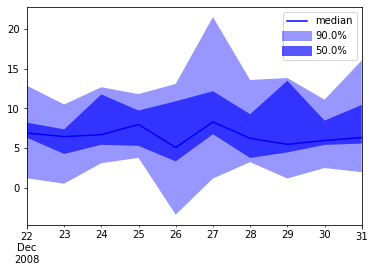

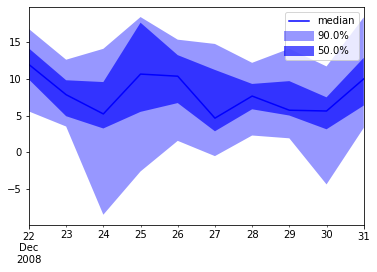

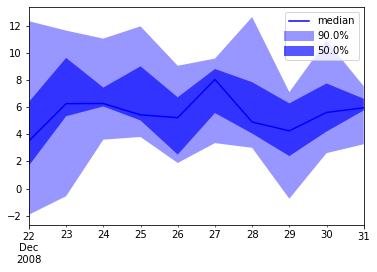

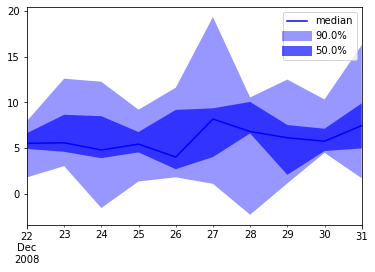

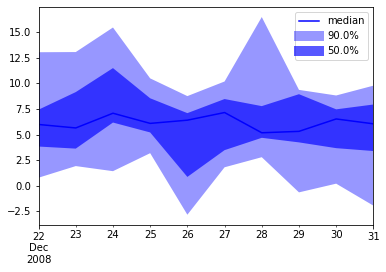

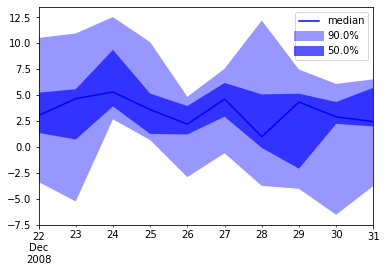

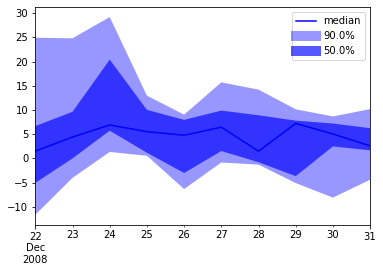

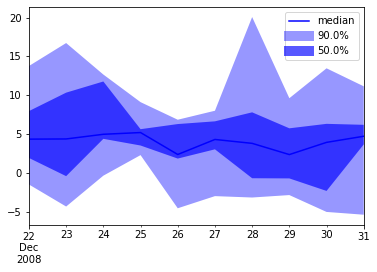

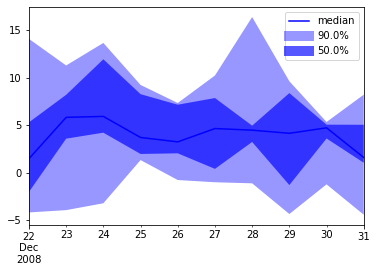

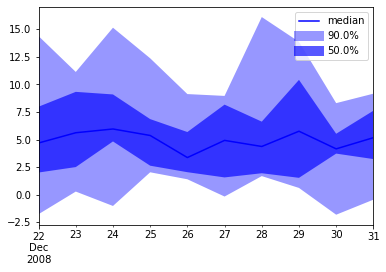

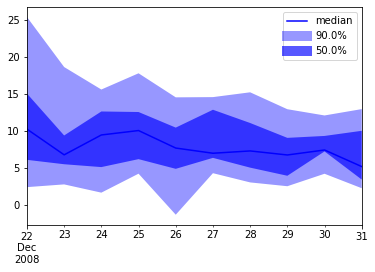

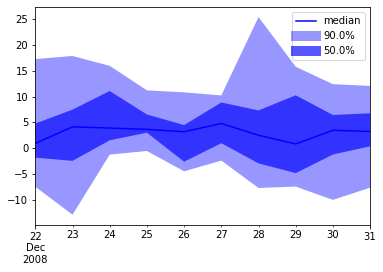

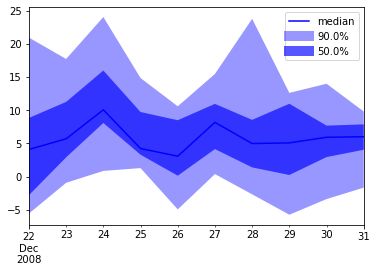

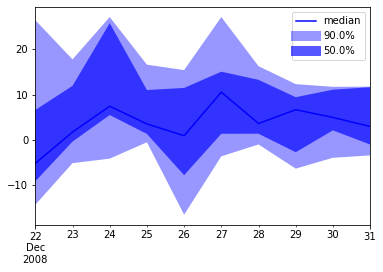

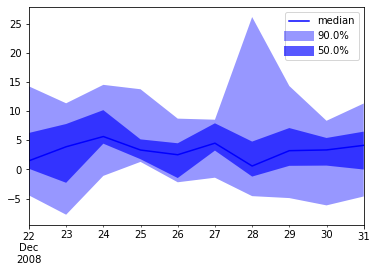

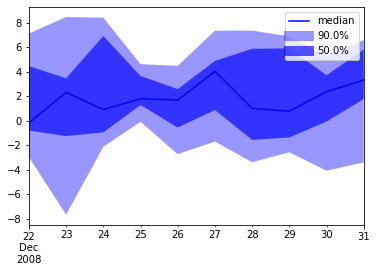

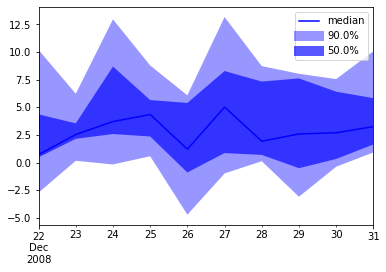

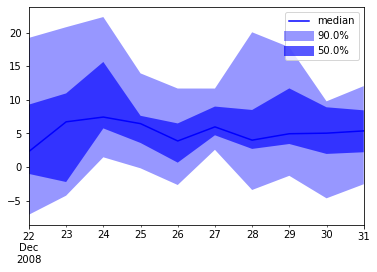

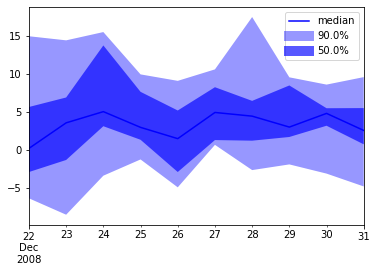

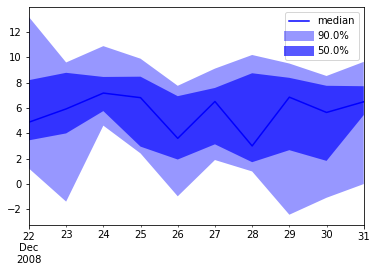

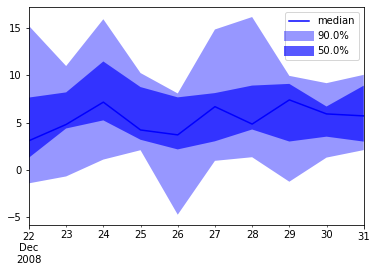

KeyboardInterrupt: 

In [ ]:
forecast = forecasts[0]
for i in range(target_dim):
    f = forecast.copy_dim(i)
    #print(f)
    #x = [9,8,22,11,12,13,4,1,8,5]
    f.plot()
    #plt.plot(x,color="Red")
    
    plt.legend()
    plt.show()

In [ ]:
forecasts